In this assignment students need to predict whether a person makes over
50K per year or not from classic adult dataset using XGBoost. The
description of the dataset is as follows:

Data Set Information:
Extraction was done by Barry Becker from the 1994 Census
database. A set of reasonably clean records was extracted using the
following conditions:

((AAGE>16) && (AGI>100) &&
(AFNLWGT>1)&& (HRSWK>0))

Attribute Information:

Listing of attributes: >50K, <=50K.

age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never worked.

fnlwgt: continuous.

education: Bachelors, Some-college, 11th, HS-grad, Prof-school,Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec- managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct,Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv,Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative,Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico,Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan,Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy,Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France,Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia,Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [1]:
# Importing necessary libraries.

import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,precision_score,recall_score
from xgboost import XGBRFClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading the csv file.

df_train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
df_test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',\
'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain',\
'capital_loss', 'hours_per_week', 'native_country', 'wage_class']

df_train.columns = col_labels
df_test.columns = col_labels

In [3]:
# Concatinating the trainand test data set.

df = pd.concat([df_train,df_test],ignore_index=True)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
# Checking the data types.

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  wage_class      48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [5]:
# Checikng for missing values.

df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

### Doing encoding.

In [6]:
# Dropping the education_num column.

df.drop(columns='education_num',inplace=True)

Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate.



In [7]:
# Categorical encoding on education column.

encoder = ce.OrdinalEncoder(mapping=[{'col':'education','mapping':{' Preschool':1,' 1st-4th':2,\
                                                                               ' 5th-6th':3,' 7th-8th':4,' 9th':5,\
                                                                               ' 10th':6,' 11th':7,' 12th':8,\
                                                                               ' HS-grad':9,' Prof-school':10,\
                                                                               ' Assoc-acdm':11,' Assoc-voc':12,\
                                                                               ' Some-college':13,' Bachelors':14,\
                                                                               ' Masters':15,' Doctorate':16}}])
df = encoder.fit_transform(df)

In [8]:
# Doing dummy encoding on other nominal categorical columns.

df_work = pd.get_dummies(data=df['workclass'],drop_first=True)

df_marital = pd.get_dummies(data=df['marital_status'],drop_first=True)

df_occupation = pd.get_dummies(data=df['occupation'],drop_first=True)

df_relation = pd.get_dummies(data=df['relationship'],drop_first=True)

df_race = pd.get_dummies(data=df['race'],drop_first=True)

df['sex'] = pd.get_dummies(data=df['sex'],drop_first=True).astype(np.int64)

df_native = pd.get_dummies(data=df['native_country'],drop_first=True)

In [9]:
# Concatinating the data_frames.

df = pd.concat([df,df_work,df_marital,df_occupation,df_relation,df_race,df_native],axis=1)

In [10]:
# Making output calsses from 'wage_class'.

df['>50k/Year'] = 0
for i in range(df.wage_class.count()):
    if df.wage_class[i]==' >50K' or df.wage_class[i]==' >50K.':
        df['>50k/Year'][i] = 1
    elif df.wage_class[i]==' <=50K'or df.wage_class[i]=='<=50K.':
        df['>50k/Year'][i] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# Dropping the unnecessary columns.

df.drop(columns=['workclass','marital_status','occupation','relationship','race'\
                       ,'native_country','wage_class'],inplace=True)

In [12]:
# Processed dataframe.

df

,age,fnlwgt,education,sex,capital_gain,capital_loss,hours_per_week,Federal-gov,Local-gov,Never-worked,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,>50k/Year
0,39,77516,14,1,2174,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,14,1,0,0,13,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,1,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,14,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,14,0,0,0,36,0,0,0,...,0,0,0,0,0,0,1,0,0,0
48838,64,321403,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
48839,38,374983,14,1,0,0,50,0,0,0,...,0,0,0,0,0,0,1,0,0,0
48840,44,83891,14,1,5455,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
# Declaring x and y.

x = df.drop(columns=['>50k/Year'])
y = df['>50k/Year']

In [14]:
# Standardising the data.

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
df_scaled = pd.DataFrame(data=x_scaled,columns=x.columns)

In [15]:
# Calculating variation inflation factor.

vif = pd.DataFrame()
vif['Feature'] = x.columns
vif["VIF"] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif.sort_values("VIF",ascending=False).head(50)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
33,Tech-support,inf
23,Craft-repair,inf
21,Adm-clerical,inf
24,Exec-managerial,inf
25,Farming-fishing,inf
34,Transport-moving,inf
26,Handlers-cleaners,inf
14,Without-pay,inf
13,State-gov,inf
12,Self-emp-not-inc,inf


In [16]:
# We have a huge Multi-collinearity, so we remove those features with high correlation.

x = df.drop(columns=['>50k/Year',' Private',' Married-civ-spouse',' White',' United-States'])
y = df['>50k/Year']

In [17]:
# Scaling the data set

x_scaled = scaler.fit_transform(x)

In [18]:
# Checking the VIF.

vif = pd.DataFrame()
vif['Feature'] = x.columns
vif["VIF"] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif.sort_values("VIF",ascending=False).head(50)

,Feature,VIF
28,Prof-specialty,3.212355
22,Exec-managerial,3.103600
21,Craft-repair,3.040579
16,Never-married,2.936283
35,Own-child,2.914514
19,Adm-clerical,2.829701
30,Sales,2.769099
33,Not-in-family,2.634138
26,Other-service,2.560947
38,Asian-Pac-Islander,2.225039


### Building model.

In [19]:
# Doing train-test split.

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2)

In [20]:
# Creating XGboost model and fitting it onto the dataset.

xgb = XGBRFClassifier(max_depth=15,learning_rate=1,verbosity=1)
xgb.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=15,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=1)

In [21]:
# Evaluation of the model.

y_pred = xgb.predict(x_test)
print("Train_score = ",xgb.score(x_train,y_train))
print("Test_Score = ",xgb.score(x_test,y_test))
print("\n\nPrecision_score = ",precision_score(y_test,y_pred))
print("Recall_score = ",recall_score(y_test,y_pred))
print("\nAUC = ",roc_auc_score(y_test,y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Train_score =  0.8880300975097893
Test_Score =  0.8610912068789026


Precision_score =  0.7815533980582524
Recall_score =  0.6034985422740525

AUC =  0.7742655577819774


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [22]:
# Confusion matrix.

confusion_matrix(y_test,y_pred)

array([[6963,  405],
       [ 952, 1449]], dtype=int64)

## Doing KFOLD

In [23]:
xgb = XGBRFClassifier(max_depth=15,learning_rate=1,verbosity=1)
kfold = KFold(n_splits=5)
kfold.get_n_splits()
train_list = []
test_list = []
precision_list = []
recall_list = []
cnt = 0
for train_index,test_index in kfold.split(x_scaled):
    x_train,x_test = x_scaled[train_index],x_scaled[test_index]
    y_train,y_test = y[train_index],y[test_index]
    xgb.fit(x_train,y_train)
    y_pred = xgb.predict(x_test)
    train_score = xgb.score(x_train,y_train)
    test_score = xgb.score(x_test,y_test)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    train_list.append(train_score)
    test_list.append(test_score)
    precision_list.append(precision)
    recall_list.append(recall)
    cnt += 1
    print("for k = {}\nTrain_score = {}\tTest_score = {}\nPrecision_score = {}\tRecall_score = {}."\
          .format(cnt,train_score,test_score,precision,recall))
print("\n\nAvg Train = {}\nAvg Test = {}\nAvg Precision = {}\nAvg Recall = {}".\
      format(np.mean(train_list),np.mean(test_list),np.mean(precision_list),np.mean(recall_list)))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for k = 1
Train_score = 0.8887722980062959	Test_score = 0.8596581021598936
Precision_score = 0.7594108019639935	Recall_score = 0.599483204134367.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for k = 2
Train_score = 0.8865968827579147	Test_score = 0.8634455932029891
Precision_score = 0.780189204229271	Recall_score = 0.5988893635198633.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for k = 3
Train_score = 0.8871884117315862	Test_score = 0.8647624897624898
Precision_score = 0.8073555166374781	Recall_score = 0.5825610783487785.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for k = 4
Train_score = 0.8880841480268209	Test_score = 0.8596437346437347
Precision_score = 0.7758816837315131	Recall_score = 0.5826569841947885.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
for k = 5
Train_score = 0.8892358089778369	Test_score = 0.8609746109746109
Precision_score = 0.7740634005763689	Recall_score = 0.5816370723256821.


Avg Train = 0.887975509900091
Avg Test = 0.8616969061487436
Avg Precision = 0.779380121427725
Avg Recall = 0.5890455405046959


##### The Average values for train score, test score, precision, recall are pretty good. So the model we build  is not an overfitting model.

### Plotting ROC_curve.

In [24]:
# ROC_AUC_score.

auc = roc_auc_score(y_test,y_pred)
auc

0.7645415553343117

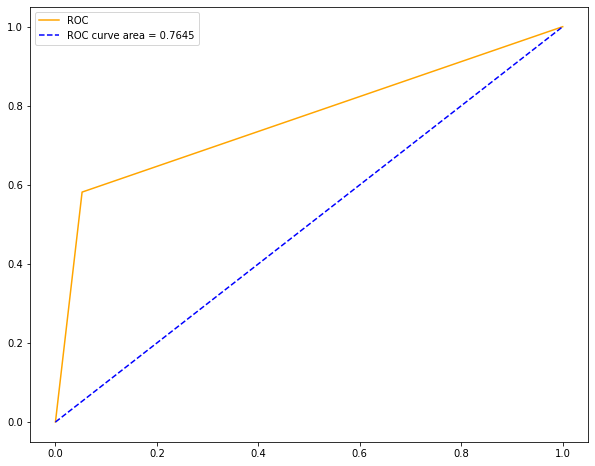

In [25]:
fpr,tpr,threshold = roc_curve(y_test,y_pred)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='blue',linestyle='--',label='ROC curve area = {}'.format(np.round(auc,4)))
plt.legend()
plt.show()